In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from scapy.all import *
import binascii
import numpy as np


# Laboratorio 5

## Parte 1
### 1. Capture 10 paquetes con la herramienta scapy, imprima el tipo de datos, la longitud y el contenido del pcap

In [2]:
ipsniff = sniff(count=10)
print("Length =", len(ipsniff))
ipsniff.summary()

Length = 10
Ether / ARP who has 192.168.2.38 says 192.168.2.39 / Padding
Ether / ARP who has 192.168.2.38 says 192.168.2.42
Ether / IP / UDP 192.168.2.206:50972 > 192.168.2.255:15600 / Raw
Ether / ARP who has 192.168.2.38 says 192.168.2.39 / Padding
Ether / ARP who has 192.168.2.38 says 192.168.2.42
Ether / IP / TCP 192.168.2.91:51676 > 192.168.2.231:8009 PA / Raw
Ether / IP / TCP 192.168.2.231:8009 > 192.168.2.91:51676 PA / Raw
Ether / IP / TCP 192.168.2.91:51676 > 192.168.2.231:8009 A
Ether / IP / UDP 192.168.2.158:49154 > 255.255.255.255:6667 / Raw
Ether / ARP who has 192.168.2.38 says 192.168.2.42


### 2. Añada al pcap de 10 paquetes el archivo analisis_paquetes.pcap

In [3]:
packets_pcap = rdpcap("analisis_paquetes.pcap")
print("Length =", len(packets_pcap))
packets_pcap

Length = 62


<analisis_paquetes.pcap: TCP:0 UDP:62 ICMP:0 Other:0>

In [4]:
packets = ipsniff + packets_pcap
print("Length =", len(packets))
packets

Length = 72


<Sniffed+analisis_paquetes.pcap: TCP:3 UDP:64 ICMP:0 Other:5>

### 3. Convierta el pcap en un DataFrame

In [5]:
#Codigo tomado de la seccion de archivos Análisis_de_paquetes.ipynb

# Obtenemos los campos de IP/TCP/UDP que seran las columnas de nuestro DF
ip_fields = [field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]

#Concatenamos todos los campos
dataframe_fields = ip_fields + ['time'] + tcp_fields + ['payload','payload_raw','payload_hex']

# Creamos un DF en blanco con los campos como columnas
df = pd.DataFrame(columns=dataframe_fields)
for packet in packets[IP]:
    # Obtenemos los valores de los campos de cada fila
    field_values = []
    # A;adimos todos los valores de los campos de IP al df
    for field in ip_fields:
        if field == 'options':
            # Obtenemos el numero de opciones del IP Header
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])
    
    field_values.append(packet.time)
    
    layer_type = type(packet[IP].payload)
    for field in tcp_fields:
        try:
            if field == 'options':
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)
    
    # Agregamos el payload
    field_values.append(len(packet[layer_type].payload))
    field_values.append(packet[layer_type].payload.original)
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))
    # Agregamos la fila al df
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df = pd.concat([df, df_append], axis=0)

# Reset Index
df = df.reset_index()
# Drop old index column
df = df.drop(columns="index")

print(df.head(5))

  version ihl tos  len     id flags frag  ttl proto chksum  ... dataofs   
0       4   5   0   63  38791    DF    0   64    17   7177  ...    None  \
1       4   5   0  162  54722    DF    0   64     6  56832  ...       8   
2       4   5   0  162  27658    DF    0   64     6  18361  ...       8   
3       4   5   0   52  54723    DF    0   64     6  56941  ...       8   
4       4   5   0  216  17058          0  255    17  46380  ...    None   

  reserved flags window chksum urgptr options payload   
0     None  None   None  11318   None    None      35  \
1        0    PA    501  34599      0       3     110   
2        0    PA    529  60439      0       3     110   
3        0     A    501  34489      0       3       0   
4     None  None   None  28251   None    None     188   

                                         payload_raw   
0          b'SEARCH BSDP/0.1\nDEVICE=0\nSERVICE=1\n'  \
1  b'\x17\x03\x03\x00i\xa1\x86\xe7r\xf3q\x19\xc9\...   
2  b'\x17\x03\x03\x00ir{\xc2\xd3#.\xfb

In [6]:
df.columns

Index(['version', 'ihl', 'tos', 'len', 'id', 'flags', 'frag', 'ttl', 'proto',
       'chksum', 'src', 'dst', 'options', 'time', 'sport', 'dport', 'seq',
       'ack', 'dataofs', 'reserved', 'flags', 'window', 'chksum', 'urgptr',
       'options', 'payload', 'payload_raw', 'payload_hex'],
      dtype='object')

### 4. Muestre los valores de las columnas: Src Address, Dst Address, Src Port y Dst Port

In [7]:
columns = ["src", "dst", "sport", "dport"]
df[columns]

,src,dst,sport,dport
0,192.168.2.206,192.168.2.255,50972,15600
1,192.168.2.91,192.168.2.231,51676,8009
2,192.168.2.231,192.168.2.91,8009,51676
3,192.168.2.91,192.168.2.231,51676,8009
4,192.168.2.158,255.255.255.255,49154,6667
...,...,...,...,...
62,84.54.22.33,10.1.10.53,53,53
63,10.1.10.53,84.54.22.33,53,53
64,84.54.22.33,10.1.10.53,53,53
65,10.1.10.53,84.54.22.33,53,53


### 5. Estadísticas
#### a. Muestre cuál es la IP origen más frecuente

In [8]:
df['src'].describe()['top']

'10.1.10.53'

#### b. Muestre cuál es la IP destino más frecuente

In [9]:
df['dst'].describe()['top']

'10.1.10.53'

#### c. ¿A qué IPs se comunica la IP del inciso a?

In [10]:
list(df[df['src'] == "10.1.10.53"]['dst'].unique())

['84.54.22.33', '75.75.75.75']

#### d. ¿A qué puertos destino se comunica la IP del inciso a?

In [11]:
list(df[df['src'] == "10.1.10.53"]['dport'].unique())

[53]

#### e. ¿A qué puertos origen se comunica la IP del inciso b?

In [12]:
list(df[df['dst'] == "10.1.10.53"]['sport'].unique())

[53]

#### f. Indique el propósito de los puertos que más aparece en los incisos d y e

El puerto 53 en UDP se utiliza para transmitir peticiones de DNS

### 6. Gráficas
#### a. Muestre una gráfica 2D, en el eje Y las IPs origen, y en el eje X la suma de los payloads enviados de dichas direcciones.

<Axes: xlabel='Suma payloads', ylabel='IP origen'>

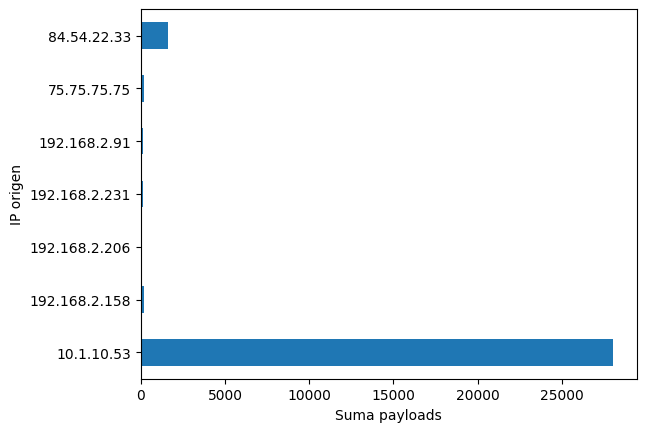

In [13]:
df.groupby('src')["payload"].sum().plot.barh(ylabel="IP origen", xlabel="Suma payloads")

#### b. Muestre una gráfica 2D, en el eje Y las IPs destino, y en el eje X la suma de los payloads recibidos en dichas direcciones.

<Axes: xlabel='Suma payloads', ylabel='IP destino'>

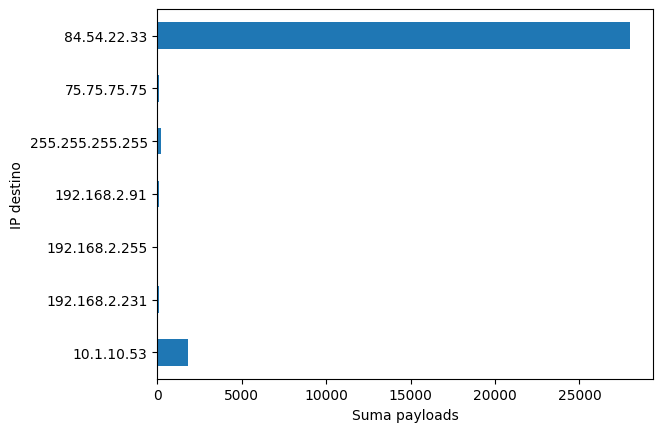

In [14]:
df.groupby('dst')["payload"].sum().plot.barh(ylabel="IP destino", xlabel="Suma payloads")

#### c. Muestre una gráfica 2D, en el eje Y los puertos origen, y en el eje X la suma de los payloads enviados de dichos puertos.

<Axes: xlabel='Suma payloads', ylabel='Puerto origen'>

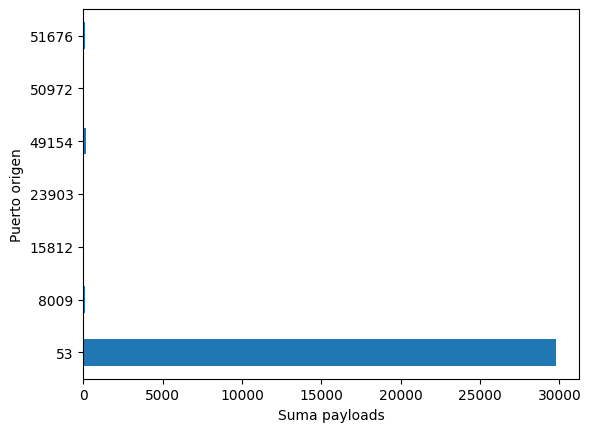

In [15]:
df.groupby('sport')["payload"].sum().plot.barh(ylabel="Puerto origen", xlabel="Suma payloads")

#### d. Muestre una gráfica 2D, en el eje Y los puertos destino, y en el eje X la suma de los payloads recibidos en dichos puertos.

<Axes: xlabel='Suma payloads', ylabel='Puerto destino'>

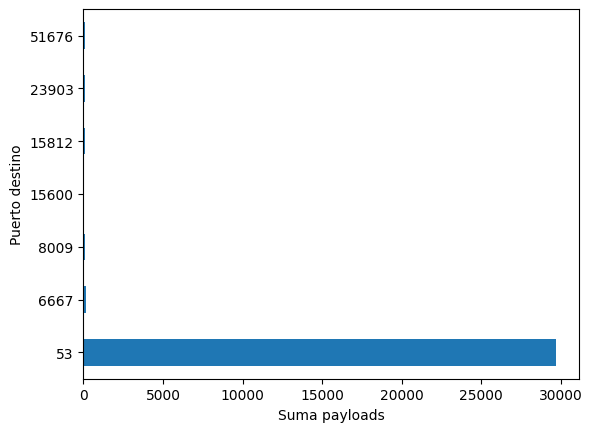

In [16]:
df.groupby('dport')["payload"].sum().plot.barh(ylabel="Puerto destino", xlabel="Suma payloads")

### 7. Investigación de payload
#### a. Cree un nuevo DF que incluya únicamente las conexiones con la dirección IP origen más frecuente.

In [17]:
df_a = df[df['src'] == "10.1.10.53"]
df_a.sample(5)

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
41,4,5,0,1039,1,,0,64,17,21144,...,None,None,None,None,39038,None,None,1011,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
9,4,5,0,1012,1,,0,64,17,21171,...,None,None,None,None,63846,None,None,984,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
61,4,5,0,1027,1,,0,64,17,21156,...,None,None,None,None,12197,None,None,999,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
25,4,5,0,1051,1,,0,64,17,21132,...,None,None,None,None,51210,None,None,1023,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
15,4,5,0,1045,1,,0,64,17,21138,...,None,None,None,None,5707,None,None,1017,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...


#### b. Obtenga un nuevo DF con las columnas Src Address, Dst Address y agrúpelas por payload

In [18]:
columns = ['src', 'dst']
df_b = df_a.groupby(columns)[['payload']].sum()
df_b

payload
src        dst                
10.1.10.53 75.75.75.75      74
           84.54.22.33   27979

#### c. Obtenga la IP que más ha intercambiado bytes con la IP más frecuente. Esta IP es sospechosa por la cantidad de bytes intercambiados, entre todas las direcciones.

In [19]:
df_b[df_b["payload"] == df_b["payload"].max()] # la ip que mas ha intercambiado con la 10.1.10.53 es la 84.54.22.33

,,payload
src,dst,
10.1.10.53,84.54.22.33,27979


#### d. Cree un nuevo DF con la conversación entre la IP más frecuente y la IP sospechosa.

In [20]:
ips = ["10.1.10.53", "84.54.22.33"]
df_d =df[df['src'].isin(ips) & df['dst'].isin(ips)]
df_d[['src', 'dst', 'sport', 'dport']]

,src,dst,sport,dport
5,10.1.10.53,84.54.22.33,53,53
6,84.54.22.33,10.1.10.53,53,53
7,10.1.10.53,84.54.22.33,53,53
8,84.54.22.33,10.1.10.53,53,53
9,10.1.10.53,84.54.22.33,53,53
10,84.54.22.33,10.1.10.53,53,53
11,10.1.10.53,84.54.22.33,53,53
12,84.54.22.33,10.1.10.53,53,53
13,10.1.10.53,84.54.22.33,53,53
14,84.54.22.33,10.1.10.53,53,53


#### e. Obtenga los payloads del DF del inciso 6(d?), y añada cada uno en un array.

In [21]:
payloads = [pay for pay in df_d['payload_raw']]
print(len(payloads))

58


#### f. Muestre el contenido del array.

In [22]:
payloads

[b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x06google\x03com\x00\x00\x1c\x00\x01\xef\xbf\xbdPNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01b\x00\x00\x00\xef\xbf\xbd\x08\x06\x00\x00\x00(\xef\xbf\xbdTR\x00\x00:\xef\xbf\xbdIDATx\xef\xbf\xbd\xef\xbf\xbd\t|T\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd;K\x12\x08;\x08\xef\xbf\xbd\nE\xef\xbf\xbd\xef\xbf\xbd$\x19\xef\xbf\xbd\xef\xbf\xbdZi\xdf\xaa-\xef\xbf\xbd;N2\xef\xbf\xbd\xef\xbf\xbdV\xef\xbf\xbdV\xef\xbf\xbda\xef\xbf\xbdZ\x11!\xef\xbf\xbd\xef\xbf\xbd\x01\xdc\xbbik[\xef\xbf\xbd.ok\xef\xbf\xbde\xef\xbf\xbd\x01\\\xef\xbf\xbd\xef\xbf\xbd]\xef\xbf\xbd-\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdd\xef\xbf\xbd\x08\xef\xbf\xbd\x08\xef\xbf\xbd\xef\xbf\xbdg\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd<\xef\xbf\xbd\xef\xbf\xbdL\x12\xef\xbf\xbd$3wf\xef\xbf\xbd\xef\xbf\xbd\x02<_\r\xef\xbf\xbdY\xef\xbf\xbdr\xef\xbf\xbd\xef\xbf\xbdy\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\x1c\r\x18\xef\xbf\xbd8c\xef\xbf\xbdew\r\x1e\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xb

#### g. Examine los primeros bytes del contenido, ¿encuentra algún dato que no haga sentido que se envie a través del puerto explicado en el inciso 5.f?

In [23]:
for item in payloads:
    print(item[:100])

b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x06google\x03com\x00\x00\x1c\x00\x01\xef\xbf\xbdPNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01b\x00\x00\x00\xef\xbf\xbd\x08\x06\x00\x00\x00(\xef\xbf\xbdTR\x00\x00:\xef\xbf\xbdIDATx\xef\xbf\xbd\xef\xbf\xbd\t|T\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef'
b'\x00\x0c\x81\x80\x00\x01\x00\x01\x00\x00\x00\x00\x06google\x03com\x00\x00\x1c\x00\x01\xc0\x0c\x00\x1c\x00\x01\x00\x00\x01+\x00\x10&\x07\xf8\xb0@\x05\x08\x07\x00\x00\x00\x00\x00\x00 \x0e'
b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x06google\x03com\x00\x00\x1c\x00\x01:\xef\xbf\xbdle:\xc7\xa9\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\x0c\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd:|\x11\xef\xbf\xbdX\xef\xbf\xbd\xef\xbf\xbdq.e\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbda\x120\xef\xbf\xbdJ}4\n9$vz\xef\xbf\xbdR\xef'
b'\x00\x0c\x81\x80\x00\x01\x00\x01\x00\x00\x00\x00\x06google\x03com\x00\x00\x1c\x00\x01\xc0\x0c\x00\x1c\x00\x01\x00\x00\x01)\x00\x10&\x07\xf8\xb0@\x05\x08\x07\x00\x00\x00\x00\x00\x00 \x0

Parece como que estuviera haciendo requests a google.com

## Parte 2
### Preprocesamiento

In [24]:
df = pd.read_csv("Train_data.csv")
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


<Axes: xlabel='class'>

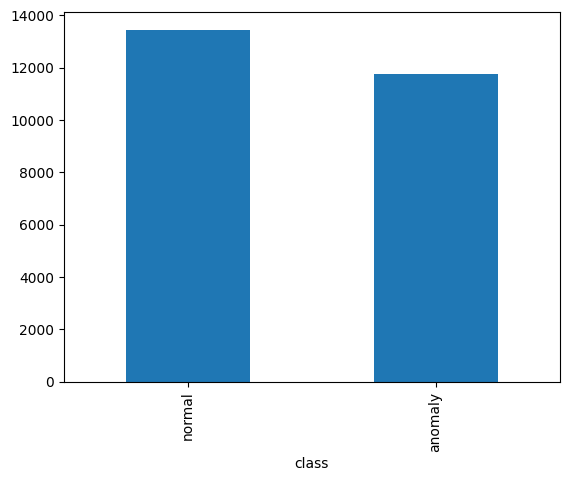

In [25]:
df["class"].value_counts().plot.bar()

Si esta balanceada la data

In [26]:
y = df["class"]
X = df.copy()
X.pop("class")
print(X.shape, y.shape)

(25192, 41) (25192,)


Las columnas protocol_type, service y flag son categóricas pero están en texto, por lo que se necesita cambiarlas para que usen números como categorías

In [27]:
cols = ["protocol_type", "service", "flag"]
X[cols] = X[cols].apply(lambda x: pd.factorize(x)[0] + 1)
X.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,1,1,1,491,0,0,0,0,0,...,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00
1,0,2,2,1,146,0,0,0,0,0,...,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00
2,0,1,3,2,0,0,0,0,0,0,...,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00
3,0,1,4,1,232,8153,0,0,0,0,...,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01
4,0,1,4,1,199,420,0,0,0,0,...,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

Se necesita escalar correctamente los datos para que naive bayes y PCA puedan ejecutarse correctamente

In [29]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

### Modelos
#### Naive Bayes sin reducción de dimensionalidad

In [30]:
model1 = GaussianNB()
model1.fit(X_train, y_train)

GaussianNB()

In [31]:
y_pred1 = model1.predict(X_test)
y_pred1

array(['normal', 'normal', 'normal', ..., 'normal', 'normal', 'normal'],
      dtype='<U7')

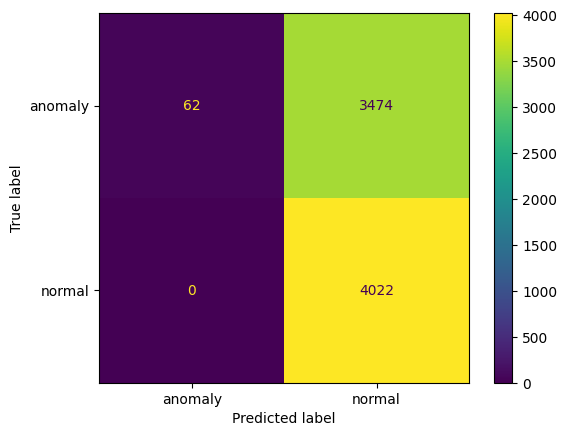

In [32]:
cm = confusion_matrix(y_test, y_pred1, labels=model1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model1.classes_)
disp.plot()

In [33]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

     anomaly       1.00      0.02      0.03      3536
      normal       0.54      1.00      0.70      4022

    accuracy                           0.54      7558
   macro avg       0.77      0.51      0.37      7558
weighted avg       0.75      0.54      0.39      7558



Como se puede observar tanto en la matriz de confusión como en los resultados estadísticos el modelo tiene una muy mala accuracy con un 54%. La matriz de confusión nos muestra un poco más a detalle qué es lo que está pasando y parece estar prediciendo todos los datos como normales y muy pocos como anomalías.

#### Naive Bayes con PCA

In [34]:
#Hyperparameters
n_components = 25
whiten = False
random_state = 123

pca = PCA(n_components = n_components, whiten=whiten, random_state=random_state)

In [35]:
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

explained_variance = pca.explained_variance_ratio_

In [36]:
print("Varianza de los %i componentes: %.4f"%(n_components, sum(pca.explained_variance_ratio_)))

Varianza de los 25 componentes: 0.9686


In [37]:
model2 = GaussianNB()
model2.fit(X_train_pca, y_train)

GaussianNB()

In [38]:
y_pred2 = model2.predict(X_test_pca)
y_pred2

array(['anomaly', 'normal', 'anomaly', ..., 'anomaly', 'anomaly',
       'anomaly'], dtype='<U7')

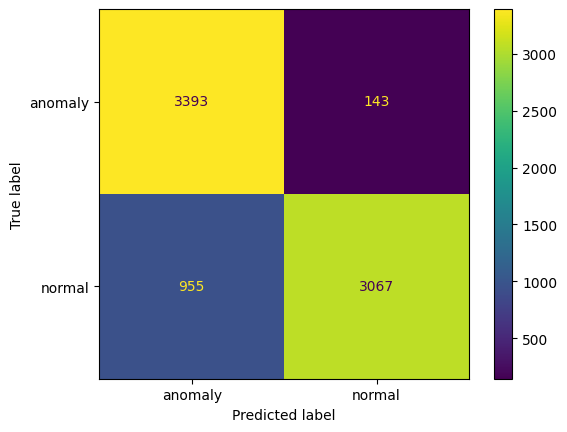

In [39]:
cm = confusion_matrix(y_test, y_pred2, labels=model2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model2.classes_)
disp.plot()

Al observar este resultado podemos notar que la reducción de dimensionalidad sí obtuvo una mejora incluso usando el mismo clasificador (naive bayes), podemos observar que la mayoría de los datos acierta con el resultado, solo tiene unos problemas cuando clasifica 955 datos que eran normales como anomalías y 143 que eran anomalías como normales.

In [40]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

     anomaly       0.78      0.96      0.86      3536
      normal       0.96      0.76      0.85      4022

    accuracy                           0.85      7558
   macro avg       0.87      0.86      0.85      7558
weighted avg       0.87      0.85      0.85      7558



Complementando la matriz de confusión con el reporte de estadísticas podemos observar buenos valores de f1-score y de accuracy (85%). Algo que es importante notar es que en la precisión la variable normal tiene un dato más alto que el de anomalía, esto es porque de los datos que clasifica como normal tuvo la mayoría correctos mientras en los que clasificó como anomalía tuvo un mayor porcentaje de desaciertos. Por otro lado el dato de recall nos indica que entre los datos que realmente eran anomalías tuvo casi todos correctos mientras que los que en realidad eran normales tuvo unos que clasificó erroneamente como anomalías.